<a href="https://colab.research.google.com/github/light-87/Audio-Denoiser/blob/main/Glucoma_Dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Raw Dataset

In [1]:
!gdown 1-h3Bv1Fjf38s42w5Cp_a-9CgXNfDGwWt

Downloading...
From (original): https://drive.google.com/uc?id=1-h3Bv1Fjf38s42w5Cp_a-9CgXNfDGwWt
From (redirected): https://drive.google.com/uc?id=1-h3Bv1Fjf38s42w5Cp_a-9CgXNfDGwWt&confirm=t&uuid=701e9a22-30b8-41ac-b871-83925d020507
To: /content/fundus_dataset.zip
100% 5.96G/5.96G [01:24<00:00, 70.4MB/s]


In [2]:
!unzip fundus_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: REFUGE/test/Masks_Cropped/T0207.png  
  inflating: REFUGE/test/Masks_Cropped/T0208.png  
  inflating: REFUGE/test/Masks_Cropped/T0209.png  
  inflating: REFUGE/test/Masks_Cropped/T0210.png  
  inflating: REFUGE/test/Masks_Cropped/T0211.png  
  inflating: REFUGE/test/Masks_Cropped/T0212.png  
  inflating: REFUGE/test/Masks_Cropped/T0213.png  
  inflating: REFUGE/test/Masks_Cropped/T0214.png  
  inflating: REFUGE/test/Masks_Cropped/T0215.png  
  inflating: REFUGE/test/Masks_Cropped/T0216.png  
  inflating: REFUGE/test/Masks_Cropped/T0217.png  
  inflating: REFUGE/test/Masks_Cropped/T0218.png  
  inflating: REFUGE/test/Masks_Cropped/T0219.png  
  inflating: REFUGE/test/Masks_Cropped/T0220.png  
  inflating: REFUGE/test/Masks_Cropped/T0221.png  
  inflating: REFUGE/test/Masks_Cropped/T0222.png  
  inflating: REFUGE/test/Masks_Cropped/T0223.png  
  inflating: REFUGE/test/Masks_Cropped/T0224.png  
  inflating: REFUGE/test/Masks_

In [3]:
import os
import json
import pandas as pd
import csv
from scipy.io import loadmat
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def explore_folders(path, max_depth=3, current_depth=0):
    """Explore folder structure to a certain depth"""
    if current_depth > max_depth:
        return

    try:
        items = os.listdir(path)
        print(f"\n{'  ' * current_depth}Exploring {path}: {len(items)} items")

        for item in sorted(items)[:10]:  # Show first 10 items
            full_path = os.path.join(path, item)
            if os.path.isdir(full_path):
                print(f"{'  ' * current_depth}[DIR] {item}")
            else:
                print(f"{'  ' * current_depth}[FILE] {item} ({os.path.getsize(full_path) / 1024:.1f} KB)")

        if len(items) > 10:
            print(f"{'  ' * current_depth}... and {len(items) - 10} more items")

        # Recursively explore subdirectories
        for item in sorted(items):
            full_path = os.path.join(path, item)
            if os.path.isdir(full_path):
                explore_folders(full_path, max_depth, current_depth + 1)
    except Exception as e:
        print(f"{'  ' * current_depth}Error exploring {path}: {e}")

def examine_csv_files(base_path):
    """Examine content of all CSV files"""
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)
                    print(f"\n--- {file_path} ---")
                    print(f"Shape: {df.shape}")
                    print("Columns:", df.columns.tolist())
                    print("First 5 rows:")
                    print(df.head())
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    # Try with different encodings or delimiters
                    try:
                        with open(file_path, 'r', encoding='latin1') as f:
                            sample = f.read(1000)
                            print(f"Sample content: {sample}")
                    except:
                        pass

def explore_json_files(base_path, max_files=3):
    """Examine content of JSON files"""
    count = 0
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    print(f"\n--- {file_path} ---")
                    print(f"Keys: {list(data.keys())}")
                    print(f"Sample content: {str(data)[:500]}...")
                    count += 1
                    if count >= max_files:
                        print("\n... (more JSON files exist) ...")
                        return
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

def explore_mat_files(base_path, max_files=3):
    """Examine content of MATLAB .mat files"""
    count = 0
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.mat'):
                file_path = os.path.join(root, file)
                try:
                    data = loadmat(file_path)
                    print(f"\n--- {file_path} ---")
                    print(f"Keys: {[k for k in data.keys() if not k.startswith('__')]}")
                    # Print a sample of the data but not the whole thing
                    for k in [k for k in data.keys() if not k.startswith('__')][:2]:
                        if isinstance(data[k], np.ndarray):
                            print(f"Key {k}: Array of shape {data[k].shape}, dtype {data[k].dtype}")
                        else:
                            print(f"Key {k}: {type(data[k])}")
                    count += 1
                    if count >= max_files:
                        print("\n... (more MAT files exist) ...")
                        return
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

def analyze_image_dimensions(base_path, pattern='', max_images=10):
    """Analyze image dimensions for different image sets"""
    print(f"\nAnalyzing image dimensions for files containing '{pattern}':")
    count = 0
    dimensions = {}

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.bmp')) and pattern in root:
                if count >= max_images:
                    break
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        folder = os.path.basename(root)
                        key = f"{folder}"
                        if key not in dimensions:
                            dimensions[key] = []
                        dimensions[key].append((width, height))
                        count += 1
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    # Print summary of dimensions
    for folder, dims in dimensions.items():
        print(f"\n{folder}:")
        for i, (width, height) in enumerate(dims):
            print(f"  Image {i+1}: {width} x {height}")

def compare_image_mask_pairs(base_path, dataset_name, max_pairs=3):
    """Find and compare image and mask pairs"""
    image_dirs = []
    mask_dirs = []

    # Find image and mask directories
    for root, dirs, _ in os.walk(os.path.join(base_path, dataset_name)):
        for d in dirs:
            if 'image' in d.lower() or 'img' in d.lower():
                image_dirs.append(os.path.join(root, d))
            elif 'mask' in d.lower():
                mask_dirs.append(os.path.join(root, d))

    print(f"\nFound {len(image_dirs)} image directories and {len(mask_dirs)} mask directories in {dataset_name}")

    # Check a few pairs
    pairs_found = 0
    for img_dir in image_dirs:
        for mask_dir in mask_dirs:
            if pairs_found >= max_pairs:
                break

            # Try to match based on directory structure
            rel_img_dir = os.path.relpath(img_dir, base_path)
            rel_mask_dir = os.path.relpath(mask_dir, base_path)

            print(f"\nChecking potential pair:")
            print(f"  Image dir: {rel_img_dir}")
            print(f"  Mask dir: {rel_mask_dir}")

            # List files
            image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))]
            mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.bmp'))]

            if not image_files or not mask_files:
                continue

            # Check for matching base names
            for img_file in image_files[:5]:
                img_base = os.path.splitext(img_file)[0]
                matching_masks = [m for m in mask_files if os.path.splitext(m)[0] == img_base]

                if matching_masks:
                    print(f"  Found matching pair: {img_file} -> {matching_masks[0]}")
                    pairs_found += 1
                    if pairs_found >= max_pairs:
                        break

            if pairs_found == 0:
                print("  No clear matching pairs found based on filename")

def main():
    base_path = '/content'

    print("=" * 50)
    print("STARTING DATASET EXPLORATION")
    print("=" * 50)

    # Check dataset folders at high level
    print("\nHigh-level dataset structure:")
    for dataset in ['ORIGA', 'REFUGE', 'G1020']:
        dataset_path = os.path.join(base_path, dataset)
        if os.path.exists(dataset_path):
            print(f"\n{dataset} found at {dataset_path}")
            subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
            print(f"  Subfolders: {subfolders}")
        else:
            print(f"\n{dataset} not found at {dataset_path}")

    # Examine CSV files
    print("\n" + "=" * 50)
    print("EXAMINING CSV FILES")
    print("=" * 50)
    examine_csv_files(base_path)

    # Examine JSON files
    print("\n" + "=" * 50)
    print("EXAMINING JSON FILES")
    print("=" * 50)
    explore_json_files(base_path)

    # Examine MAT files
    print("\n" + "=" * 50)
    print("EXAMINING MAT FILES")
    print("=" * 50)
    explore_mat_files(base_path)

    # Analyze image dimensions
    print("\n" + "=" * 50)
    print("ANALYZING IMAGE DIMENSIONS")
    print("=" * 50)
    for pattern in ['Original', 'Cropped', 'Square']:
        analyze_image_dimensions(base_path, pattern, max_images=5)

    # Compare image-mask pairs
    print("\n" + "=" * 50)
    print("COMPARING IMAGE-MASK PAIRS")
    print("=" * 50)
    for dataset in ['ORIGA', 'REFUGE', 'G1020']:
        compare_image_mask_pairs(base_path, dataset)

    # Check for train/val/test splits
    print("\n" + "=" * 50)
    print("CHECKING DATASET SPLITS")
    print("=" * 50)

    # REFUGE has explicit splits
    refuge_path = os.path.join(base_path, 'REFUGE')
    if os.path.exists(refuge_path):
        for split in ['train', 'val', 'test']:
            split_path = os.path.join(refuge_path, split)
            if os.path.exists(split_path):
                num_images = len([f for f in os.listdir(os.path.join(split_path, 'Images'))
                               if f.lower().endswith('.jpg')])
                print(f"REFUGE {split} set: {num_images} images")

                # Check if split has index.json
                index_path = os.path.join(split_path, 'index.json')
                if os.path.exists(index_path):
                    try:
                        with open(index_path, 'r') as f:
                            index_data = json.load(f)
                        print(f"  index.json keys: {list(index_data.keys())}")
                        print(f"  Sample data: {str(index_data)[:200]}...")
                    except Exception as e:
                        print(f"  Error reading index.json: {e}")

if __name__ == "__main__":
    main()

STARTING DATASET EXPLORATION

High-level dataset structure:

ORIGA found at /content/ORIGA
  Subfolders: ['Masks_Square', 'Images_Square', 'Semi-automatic-annotations', 'Masks', 'Images_Cropped', 'Images', 'Masks_Cropped']

REFUGE found at /content/REFUGE
  Subfolders: ['val', 'Masks_Square', 'Images_Square', 'test', 'train']

G1020 found at /content/G1020
  Subfolders: ['NerveRemoved_Images', 'Masks_Square', 'Images_Square', 'Masks', 'Images_Cropped', 'Images', 'Masks_Cropped']

EXAMINING CSV FILES

--- /content/ORIGA/OrigaList.csv ---
Shape: (650, 5)
Columns: ['Eye', 'Filename', 'ExpCDR', 'Set', 'Glaucoma']
First 5 rows:
  Eye Filename  ExpCDR Set  Glaucoma
0  OD  001.jpg  0.7097   A         0
1  OS  002.jpg  0.6953   A         0
2  OS  003.jpg  0.9629   A         0
3  OD  004.jpg  0.7246   A         0
4  OS  005.jpg  0.6138   A         0

--- /content/ORIGA/origa_info.csv ---
Shape: (650, 7)
Columns: ['Image', 'Source', 'Cropped', 'CDR', 'Ecc-Cup', 'Ecc-Disc', 'Label']
First 5 rows:

In [4]:
import os
import json
import pandas as pd
import glob
from tqdm import tqdm
import numpy as np
from PIL import Image

def main():
    base_path = '/content'
    output_file = os.path.join(base_path, 'consolidated_glaucoma_dataset.csv')

    # Create an empty DataFrame to store all data
    columns = [
        'file_id', 'dataset', 'split', 'image_path', 'image_cropped_path', 'image_square_path',
        'mask_path', 'mask_cropped_path', 'mask_square_path', 'nerve_removed_path',
        'label', 'has_glaucoma', 'eye_laterality', 'cdr', 'ecc_cup', 'ecc_disc',
        'fovea_x', 'fovea_y', 'image_width', 'image_height'
    ]

    all_data = pd.DataFrame(columns=columns)

    print("Starting dataset consolidation...")

    # Process ORIGA dataset
    print("\nProcessing ORIGA dataset...")
    origa_data = process_origa(os.path.join(base_path, 'ORIGA'))
    all_data = pd.concat([all_data, origa_data], ignore_index=True)
    print(f"Added {len(origa_data)} ORIGA images")

    # Process REFUGE dataset
    print("\nProcessing REFUGE dataset...")
    refuge_data = process_refuge(os.path.join(base_path, 'REFUGE'))
    all_data = pd.concat([all_data, refuge_data], ignore_index=True)
    print(f"Added {len(refuge_data)} REFUGE images")

    # Process G1020 dataset
    print("\nProcessing G1020 dataset...")
    g1020_data = process_g1020(os.path.join(base_path, 'G1020'))
    all_data = pd.concat([all_data, g1020_data], ignore_index=True)
    print(f"Added {len(g1020_data)} G1020 images")

    # Save consolidated dataset
    all_data.to_csv(output_file, index=False)
    print(f"\nConsolidated dataset saved to {output_file}")
    print(f"Total images: {len(all_data)}")

    # Print dataset statistics
    print("\nDataset Statistics:")
    print(f"Total Glaucoma cases: {all_data['has_glaucoma'].sum()}")
    print(f"Total Normal cases: {len(all_data) - all_data['has_glaucoma'].sum()}")
    print("\nDistribution by dataset:")
    print(all_data['dataset'].value_counts())
    print("\nDistribution by split:")
    print(all_data['split'].value_counts())

def process_origa(dataset_path):
    """Process ORIGA dataset and return a DataFrame"""

    # Read metadata files
    origa_list_path = os.path.join(dataset_path, 'OrigaList.csv')
    origa_info_path = os.path.join(dataset_path, 'origa_info.csv')

    origa_list = pd.read_csv(origa_list_path)
    origa_info = pd.read_csv(origa_info_path)

    # Initialize DataFrame
    origa_data = pd.DataFrame(columns=[
        'file_id', 'dataset', 'split', 'image_path', 'image_cropped_path', 'image_square_path',
        'mask_path', 'mask_cropped_path', 'mask_square_path', 'nerve_removed_path',
        'label', 'has_glaucoma', 'eye_laterality', 'cdr', 'ecc_cup', 'ecc_disc',
        'fovea_x', 'fovea_y', 'image_width', 'image_height'
    ])

    # Identify all image files
    image_files = glob.glob(os.path.join(dataset_path, 'Images', '*.jpg'))

    # Process each image
    for img_path in tqdm(image_files, desc="Processing ORIGA images"):
        img_filename = os.path.basename(img_path)
        img_id = os.path.splitext(img_filename)[0]

        # Find metadata for this image
        img_meta = origa_list[origa_list['Filename'] == img_filename]

        if len(img_meta) == 0:
            print(f"Warning: No metadata found for {img_filename}, skipping")
            continue

        # Find additional info
        img_info = origa_info[origa_info['Image'].str.contains(f"/{img_id}.jpg", na=False)]

        # Get image dimensions
        try:
            with Image.open(img_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"Error reading image dimensions for {img_path}: {e}")
            width, height = None, None

        # Construct paths for all versions
        image_path = os.path.join(dataset_path, 'Images', img_filename)
        image_cropped_path = os.path.join(dataset_path, 'Images_Cropped', img_filename)
        image_square_path = os.path.join(dataset_path, 'Images_Square', img_filename)

        mask_path = os.path.join(dataset_path, 'Masks', f"{img_id}.png")
        mask_cropped_path = os.path.join(dataset_path, 'Masks_Cropped', f"{img_id}.png")
        mask_square_path = os.path.join(dataset_path, 'Masks_Square', f"{img_id}.png")

        # Get label info
        has_glaucoma = int(img_meta['Glaucoma'].iloc[0])
        eye_laterality = img_meta['Eye'].iloc[0]  # OD (right) or OS (left)

        # Get CDR and other metrics if available
        cdr = float(img_info['CDR'].iloc[0]) if len(img_info) > 0 and 'CDR' in img_info.columns else None
        ecc_cup = float(img_info['Ecc-Cup'].iloc[0]) if len(img_info) > 0 and 'Ecc-Cup' in img_info.columns else None
        ecc_disc = float(img_info['Ecc-Disc'].iloc[0]) if len(img_info) > 0 and 'Ecc-Disc' in img_info.columns else None

        # Add to dataset
        origa_data = pd.concat([origa_data, pd.DataFrame([{
            'file_id': img_id,
            'dataset': 'ORIGA',
            'split': img_meta['Set'].iloc[0],  # A or Z sets
            'image_path': image_path,
            'image_cropped_path': image_cropped_path if os.path.exists(image_cropped_path) else None,
            'image_square_path': image_square_path if os.path.exists(image_square_path) else None,
            'mask_path': mask_path if os.path.exists(mask_path) else None,
            'mask_cropped_path': mask_cropped_path if os.path.exists(mask_cropped_path) else None,
            'mask_square_path': mask_square_path if os.path.exists(mask_square_path) else None,
            'nerve_removed_path': None,  # ORIGA doesn't have nerve removed images
            'label': has_glaucoma,
            'has_glaucoma': has_glaucoma,
            'eye_laterality': eye_laterality,
            'cdr': cdr,
            'ecc_cup': ecc_cup,
            'ecc_disc': ecc_disc,
            'fovea_x': None,  # ORIGA doesn't have fovea coordinates
            'fovea_y': None,
            'image_width': width,
            'image_height': height
        }])], ignore_index=True)

    return origa_data

def process_refuge(dataset_path):
    """Process REFUGE dataset and return a DataFrame"""

    # Initialize DataFrame
    refuge_data = pd.DataFrame(columns=[
        'file_id', 'dataset', 'split', 'image_path', 'image_cropped_path', 'image_square_path',
        'mask_path', 'mask_cropped_path', 'mask_square_path', 'nerve_removed_path',
        'label', 'has_glaucoma', 'eye_laterality', 'cdr', 'ecc_cup', 'ecc_disc',
        'fovea_x', 'fovea_y', 'image_width', 'image_height'
    ])

    # Process each split (train, val, test)
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dataset_path, split)

        # Load index.json which contains metadata
        index_path = os.path.join(split_path, 'index.json')
        if not os.path.exists(index_path):
            print(f"Warning: index.json not found for {split} split")
            continue

        with open(index_path, 'r') as f:
            index_data = json.load(f)

        # Process each image in the split
        for idx, img_info in tqdm(index_data.items(), desc=f"Processing REFUGE {split}"):
            img_filename = img_info['ImgName']
            img_id = os.path.splitext(img_filename)[0]

            # Construct paths for all versions
            image_path = os.path.join(split_path, 'Images', img_filename)
            image_cropped_path = os.path.join(split_path, 'Images_Cropped', img_filename)

            # Square images are stored at the root level for REFUGE
            image_square_path = os.path.join(dataset_path, 'Images_Square', img_filename)

            # Mask paths
            mask_filename = f"{img_id}.png"
            mask_path = os.path.join(split_path, 'Masks', mask_filename)
            mask_cropped_path = os.path.join(split_path, 'Masks_Cropped', mask_filename)
            mask_square_path = os.path.join(dataset_path, 'Masks_Square', mask_filename)

            # Get image dimensions from the metadata
            width = img_info.get('Size_X', None)
            height = img_info.get('Size_Y', None)

            # Get label info
            has_glaucoma = img_info.get('Label', None)
            if has_glaucoma is None and split == 'test':
                # Test set might not have labels, use placeholder
                has_glaucoma = -1

            # Get fovea coordinates (unique to REFUGE)
            fovea_x = img_info.get('Fovea_X', None)
            fovea_y = img_info.get('Fovea_Y', None)

            # Add to dataset
            refuge_data = pd.concat([refuge_data, pd.DataFrame([{
                'file_id': img_id,
                'dataset': 'REFUGE',
                'split': split,
                'image_path': image_path,
                'image_cropped_path': image_cropped_path if os.path.exists(image_cropped_path) else None,
                'image_square_path': image_square_path if os.path.exists(image_square_path) else None,
                'mask_path': mask_path if os.path.exists(mask_path) else None,
                'mask_cropped_path': mask_cropped_path if os.path.exists(mask_cropped_path) else None,
                'mask_square_path': mask_square_path if os.path.exists(mask_square_path) else None,
                'nerve_removed_path': None,  # REFUGE doesn't have nerve removed images
                'label': has_glaucoma,
                'has_glaucoma': 1 if has_glaucoma == 1 else 0 if has_glaucoma == 0 else -1,
                'eye_laterality': None,  # REFUGE doesn't specify eye laterality
                'cdr': None,  # REFUGE doesn't provide CDR directly
                'ecc_cup': None,
                'ecc_disc': None,
                'fovea_x': fovea_x,
                'fovea_y': fovea_y,
                'image_width': width,
                'image_height': height
            }])], ignore_index=True)

    return refuge_data

def process_g1020(dataset_path):
    """Process G1020 dataset and return a DataFrame"""

    # Read metadata file
    g1020_csv_path = os.path.join(dataset_path, 'G1020.csv')
    g1020_meta = pd.read_csv(g1020_csv_path)

    # Initialize DataFrame
    g1020_data = pd.DataFrame(columns=[
        'file_id', 'dataset', 'split', 'image_path', 'image_cropped_path', 'image_square_path',
        'mask_path', 'mask_cropped_path', 'mask_square_path', 'nerve_removed_path',
        'label', 'has_glaucoma', 'eye_laterality', 'cdr', 'ecc_cup', 'ecc_disc',
        'fovea_x', 'fovea_y', 'image_width', 'image_height'
    ])

    # Process each image in the dataset
    for _, row in tqdm(g1020_meta.iterrows(), desc="Processing G1020 images", total=len(g1020_meta)):
        img_filename = row['imageID']
        img_id = os.path.splitext(img_filename)[0]

        # Construct paths for all versions
        image_path = os.path.join(dataset_path, 'Images', img_filename)
        image_cropped_path = os.path.join(dataset_path, 'Images_Cropped', 'img', img_filename)
        if not os.path.exists(image_cropped_path):
            image_cropped_path = os.path.join(dataset_path, 'Images_Cropped', img_filename)

        image_square_path = os.path.join(dataset_path, 'Images_Square', img_filename)

        # Unique to G1020: nerve removed images
        nerve_removed_path = os.path.join(dataset_path, 'NerveRemoved_Images', img_filename)

        # Mask paths
        mask_filename = f"{img_id}.png"
        mask_path = os.path.join(dataset_path, 'Masks', mask_filename)

        mask_cropped_path = os.path.join(dataset_path, 'Masks_Cropped', 'img', mask_filename)
        if not os.path.exists(mask_cropped_path):
            mask_cropped_path = os.path.join(dataset_path, 'Masks_Cropped', mask_filename)

        mask_square_path = os.path.join(dataset_path, 'Masks_Square', mask_filename)

        # Get image dimensions
        width, height = None, None
        try:
            if os.path.exists(image_path):
                with Image.open(image_path) as img:
                    width, height = img.size
        except Exception as e:
            print(f"Error reading image dimensions for {image_path}: {e}")

        # Get label info
        has_glaucoma = int(row['binaryLabels'])

        # Add to dataset
        g1020_data = pd.concat([g1020_data, pd.DataFrame([{
            'file_id': img_id,
            'dataset': 'G1020',
            'split': 'unspecified',  # G1020 doesn't specify train/test split
            'image_path': image_path if os.path.exists(image_path) else None,
            'image_cropped_path': image_cropped_path if os.path.exists(image_cropped_path) else None,
            'image_square_path': image_square_path if os.path.exists(image_square_path) else None,
            'mask_path': mask_path if os.path.exists(mask_path) else None,
            'mask_cropped_path': mask_cropped_path if os.path.exists(mask_cropped_path) else None,
            'mask_square_path': mask_square_path if os.path.exists(mask_square_path) else None,
            'nerve_removed_path': nerve_removed_path if os.path.exists(nerve_removed_path) else None,
            'label': has_glaucoma,
            'has_glaucoma': has_glaucoma,
            'eye_laterality': None,  # G1020 doesn't specify eye laterality
            'cdr': None,  # G1020 doesn't provide CDR directly
            'ecc_cup': None,
            'ecc_disc': None,
            'fovea_x': None,  # G1020 doesn't have fovea coordinates
            'fovea_y': None,
            'image_width': width,
            'image_height': height
        }])], ignore_index=True)

    return g1020_data

if __name__ == "__main__":
    main()

Starting dataset consolidation...

Processing ORIGA dataset...


Processing ORIGA images:   0%|          | 0/650 [00:00<?, ?it/s]<ipython-input-4-1618646f39c2>:120: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  origa_data = pd.concat([origa_data, pd.DataFrame([{
Processing ORIGA images: 100%|██████████| 650/650 [00:04<00:00, 149.20it/s]
<ipython-input-4-1618646f39c2>:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, origa_data], ignore_index=True)


Added 650 ORIGA images

Processing REFUGE dataset...


Processing REFUGE train:   0%|          | 0/400 [00:00<?, ?it/s]<ipython-input-4-1618646f39c2>:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  refuge_data = pd.concat([refuge_data, pd.DataFrame([{
Processing REFUGE test: 100%|██████████| 400/400 [00:01<00:00, 206.40it/s]
<ipython-input-4-1618646f39c2>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, refuge_data], ignore_index=True)


Added 1200 REFUGE images

Processing G1020 dataset...


Processing G1020 images: 100%|██████████| 1020/1020 [00:07<00:00, 145.35it/s]
<ipython-input-4-1618646f39c2>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, g1020_data], ignore_index=True)


Added 1020 G1020 images

Consolidated dataset saved to /content/consolidated_glaucoma_dataset.csv
Total images: 2870

Dataset Statistics:
Total Glaucoma cases: 144
Total Normal cases: 2726

Distribution by dataset:
dataset
REFUGE    1200
G1020     1020
ORIGA      650
Name: count, dtype: int64

Distribution by split:
split
unspecified    1020
train           400
val             400
test            400
A               325
B               325
Name: count, dtype: int64


In [5]:
df = pd.read_csv("/content/consolidated_glaucoma_dataset.csv")
df.tail(20)

,file_id,dataset,split,image_path,image_cropped_path,image_square_path,mask_path,mask_cropped_path,mask_square_path,nerve_removed_path,label,has_glaucoma,eye_laterality,cdr,ecc_cup,ecc_disc,fovea_x,fovea_y,image_width,image_height
2850,image_3144,G1020,unspecified,/content/G1020/Images/image_3144.jpg,/content/G1020/Images_Cropped/img/image_3144.jpg,/content/G1020/Images_Square/image_3144.jpg,/content/G1020/Masks/image_3144.png,/content/G1020/Masks_Cropped/img/image_3144.png,/content/G1020/Masks_Square/image_3144.png,/content/G1020/NerveRemoved_Images/image_3144.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2089,1944
2851,image_3159,G1020,unspecified,/content/G1020/Images/image_3159.jpg,/content/G1020/Images_Cropped/img/image_3159.jpg,/content/G1020/Images_Square/image_3159.jpg,/content/G1020/Masks/image_3159.png,/content/G1020/Masks_Cropped/img/image_3159.png,/content/G1020/Masks_Square/image_3159.png,/content/G1020/NerveRemoved_Images/image_3159.jpg,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3006,2424
2852,image_3160,G1020,unspecified,/content/G1020/Images/image_3160.jpg,/content/G1020/Images_Cropped/img/image_3160.jpg,/content/G1020/Images_Square/image_3160.jpg,/content/G1020/Masks/image_3160.png,/content/G1020/Masks_Cropped/img/image_3160.png,/content/G1020/Masks_Square/image_3160.png,/content/G1020/NerveRemoved_Images/image_3160.jpg,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3004,2423
2853,image_3163,G1020,unspecified,/content/G1020/Images/image_3163.jpg,/content/G1020/Images_Cropped/img/image_3163.jpg,/content/G1020/Images_Square/image_3163.jpg,/content/G1020/Masks/image_3163.png,/content/G1020/Masks_Cropped/img/image_3163.png,/content/G1020/Masks_Square/image_3163.png,/content/G1020/NerveRemoved_Images/image_3163.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2218,1944
2854,image_3164,G1020,unspecified,/content/G1020/Images/image_3164.jpg,/content/G1020/Images_Cropped/img/image_3164.jpg,/content/G1020/Images_Square/image_3164.jpg,/content/G1020/Masks/image_3164.png,/content/G1020/Masks_Cropped/img/image_3164.png,/content/G1020/Masks_Square/image_3164.png,/content/G1020/NerveRemoved_Images/image_3164.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,3006,2424
2855,image_3165,G1020,unspecified,/content/G1020/Images/image_3165.jpg,/content/G1020/Images_Cropped/img/image_3165.jpg,/content/G1020/Images_Square/image_3165.jpg,/content/G1020/Masks/image_3165.png,/content/G1020/Masks_Cropped/img/image_3165.png,/content/G1020/Masks_Square/image_3165.png,/content/G1020/NerveRemoved_Images/image_3165.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,3005,2424
2856,image_3166,G1020,unspecified,/content/G1020/Images/image_3166.jpg,/content/G1020/Images_Cropped/img/image_3166.jpg,/content/G1020/Images_Square/image_3166.jpg,/content/G1020/Masks/image_3166.png,/content/G1020/Masks_Cropped/img/image_3166.png,/content/G1020/Masks_Square/image_3166.png,/content/G1020/NerveRemoved_Images/image_3166.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,3005,2425
2857,image_3167,G1020,unspecified,/content/G1020/Images/image_3167.jpg,/content/G1020/Images_Cropped/img/image_3167.jpg,/content/G1020/Images_Square/image_3167.jpg,/content/G1020/Masks/image_3167.png,/content/G1020/Masks_Cropped/img/image_3167.png,/content/G1020/Masks_Square/image_3167.png,/content/G1020/NerveRemoved_Images/image_3167.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2088,1944
2858,image_3168,G1020,unspecified,/content/G1020/Images/image_3168.jpg,/content/G1020/Images_Cropped/img/image_3168.jpg,/content/G1020/Images_Square/image_3168.jpg,/content/G1020/Masks/image_3168.png,/content/G1020/Masks_Cropped/img/image_3168.png,/content/G1020/Masks_Square/image_3168.png,/content/G1020/NerveRemoved_Images/image_3168.jpg,1,1,NaN,NaN,NaN,NaN,NaN,NaN,3004,2424
2859,image_3169,G1020,unspecified,/content/G1020/Images/image_3169.jpg,/content/G1020/Images_Cropped/img/image_3169.jpg,/content/G1020/Images_Square/image_3169.jpg,/content/G1020/Masks/image_3169.png,/content/G1020/Masks_Cropped/img/image_3169.png,/content/G1020/Masks_Square/image_3169.png,/content/G1020/NerveRemoved_Images/image_3169.jpg,0,0,NaN,NaN,NaN,N

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file_id             2870 non-null   object 
 1   dataset             2870 non-null   object 
 2   split               2870 non-null   object 
 3   image_path          2870 non-null   object 
 4   image_cropped_path  2870 non-null   object 
 5   image_square_path   2870 non-null   object 
 6   mask_path           2870 non-null   object 
 7   mask_cropped_path   2870 non-null   object 
 8   mask_square_path    2870 non-null   object 
 9   nerve_removed_path  1020 non-null   object 
 10  label               2870 non-null   int64  
 11  has_glaucoma        2870 non-null   int64  
 12  eye_laterality      650 non-null    object 
 13  cdr                 650 non-null    float64
 14  ecc_cup             650 non-null    float64
 15  ecc_disc            650 non-null    float64
 16  fovea_

Loading dataset from /content/consolidated_glaucoma_dataset.csv...
Loaded 2870 samples

=== DATASET OVERVIEW ===
Total samples: 2870

Samples per dataset:
  REFUGE: 1200 (41.8%)
  G1020: 1020 (35.5%)
  ORIGA: 650 (22.6%)

Samples per split:
  unspecified: 1020 (35.5%)
  train: 400 (13.9%)
  val: 400 (13.9%)
  test: 400 (13.9%)
  A: 325 (11.3%)
  B: 325 (11.3%)

Glaucoma distribution:
  Normal: 1926 (78.0%)
  Glaucoma: 544 (22.0%)

Missing values:
  nerve_removed_path: 1850 (64.5%)
  eye_laterality: 2220 (77.4%)
  cdr: 2220 (77.4%)
  ecc_cup: 2220 (77.4%)
  ecc_disc: 2220 (77.4%)
  fovea_x: 2070 (72.1%)
  fovea_y: 2070 (72.1%)

=== DATASET CHARACTERISTICS SUMMARY ===

ORIGA Dataset:
  Total samples: 650
  Class Distribution: 168 Glaucoma (25.8%), 482 Normal (74.2%)
  Dataset Splits: B, A
  Available Variants: Original Images, Cropped Images, Square Images, Segmentation Masks
  Available Metadata: Cup-to-Disc Ratio (CDR), Cup Eccentricity, Disc Eccentricity, Eye Laterality (OD/OS)
  Imag

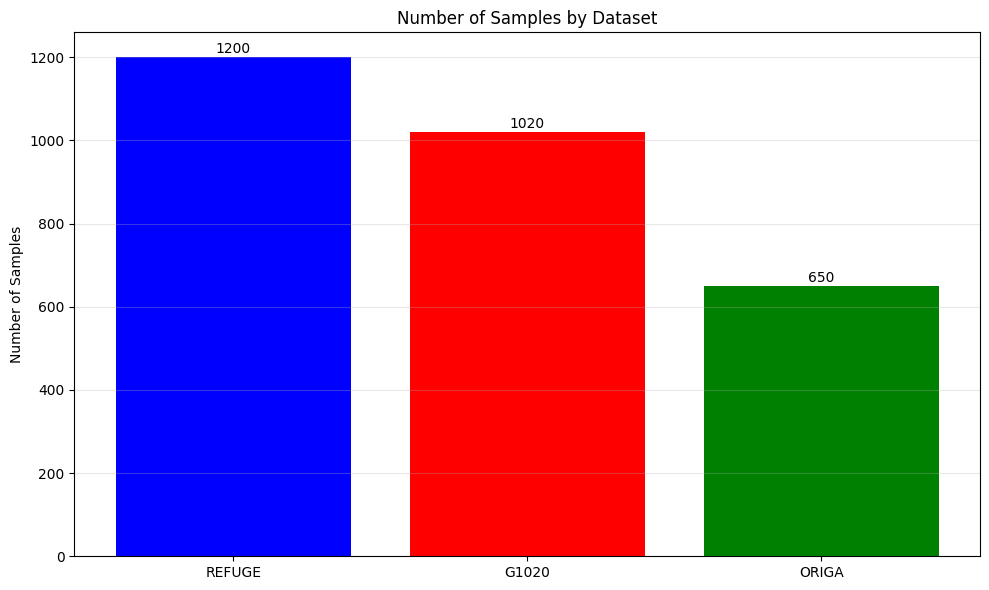

<Figure size 1200x600 with 0 Axes>

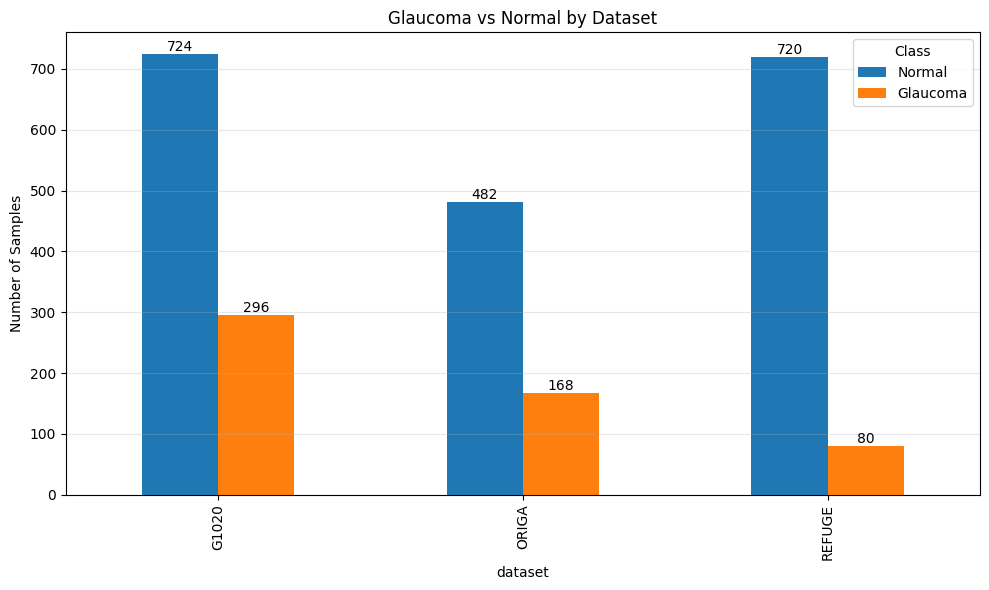


=== METADATA AVAILABILITY ===

Metadata Availability by Dataset (%):
Dataset    cdr ecc_cup ecc_disc fovea_x fovea_y eye_laterality
  ORIGA 100.0%  100.0%   100.0%    0.0%    0.0%         100.0%
 REFUGE   0.0%    0.0%     0.0%   66.7%   66.7%           0.0%
  G1020   0.0%    0.0%     0.0%    0.0%    0.0%           0.0%

Detailed metadata availability:

ORIGA Dataset:
  cdr: 650/650 (100.0%)
  ecc_cup: 650/650 (100.0%)
  ecc_disc: 650/650 (100.0%)
  fovea_x: Not available
  fovea_y: Not available
  eye_laterality: 650/650 (100.0%)

REFUGE Dataset:
  cdr: Not available
  ecc_cup: Not available
  ecc_disc: Not available
  fovea_x: 800/1200 (66.7%)
  fovea_y: 800/1200 (66.7%)
  eye_laterality: Not available

G1020 Dataset:
  cdr: Not available
  ecc_cup: Not available
  ecc_disc: Not available
  fovea_x: Not available
  fovea_y: Not available
  eye_laterality: Not available

=== IMAGE VARIANTS AVAILABILITY ===

Image Variants Availability by Dataset (%):
Dataset image_path image_cropped_p

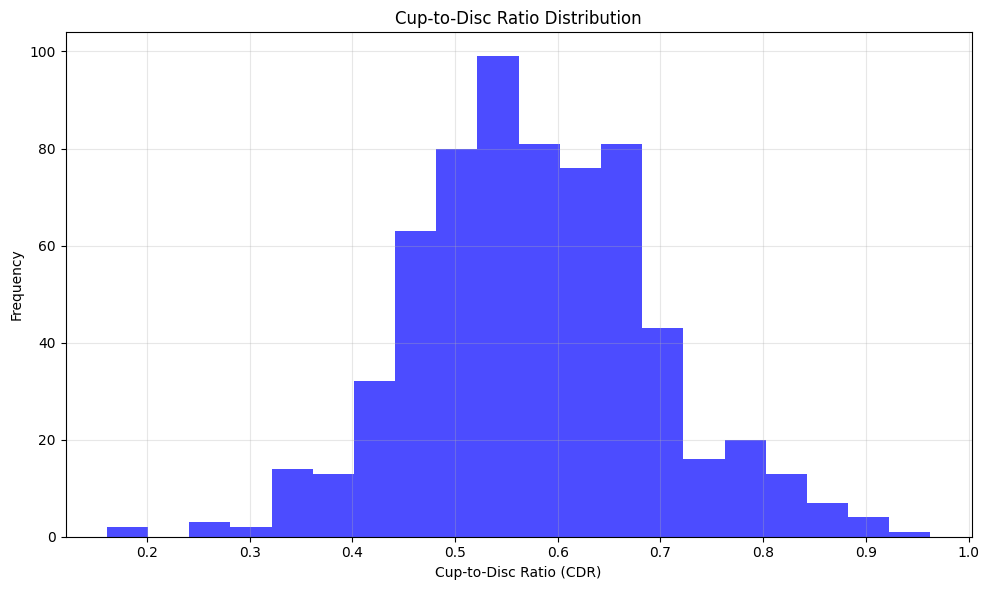

<ipython-input-7-2b80997cb63d>:218: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_cdr, glaucoma_cdr], labels=['Normal', 'Glaucoma'])


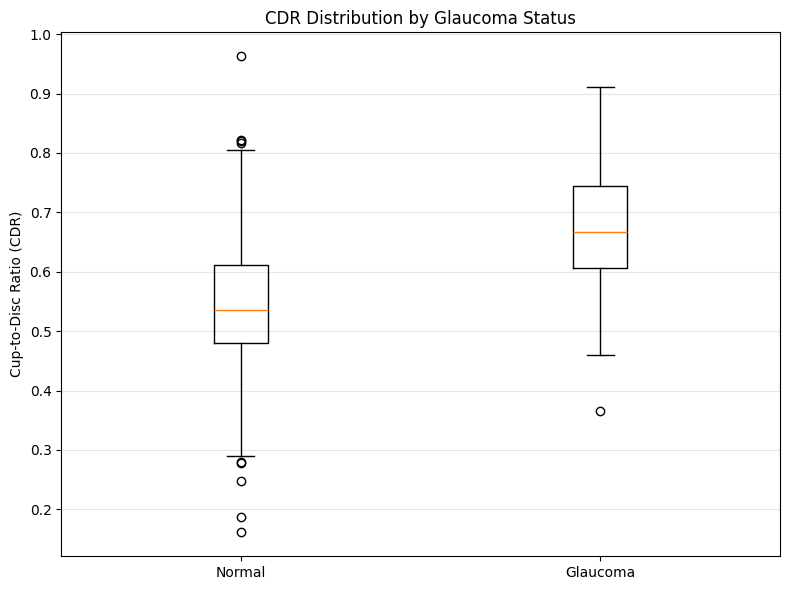


CDR Threshold Analysis:
  CDR > 0.5 threshold: 52.0% accuracy
  CDR > 0.6 threshold: 73.5% accuracy
  CDR > 0.7 threshold: 78.5% accuracy
  CDR > 0.8 threshold: 76.6% accuracy

=== SAMPLE IMAGES VISUALIZATION ===

Attempting to visualize sample images from ORIGA dataset...

Image 1 from ORIGA:
  Path: /content/ORIGA/Images/176.jpg
  File ID: 176
  Glaucoma Status: Normal


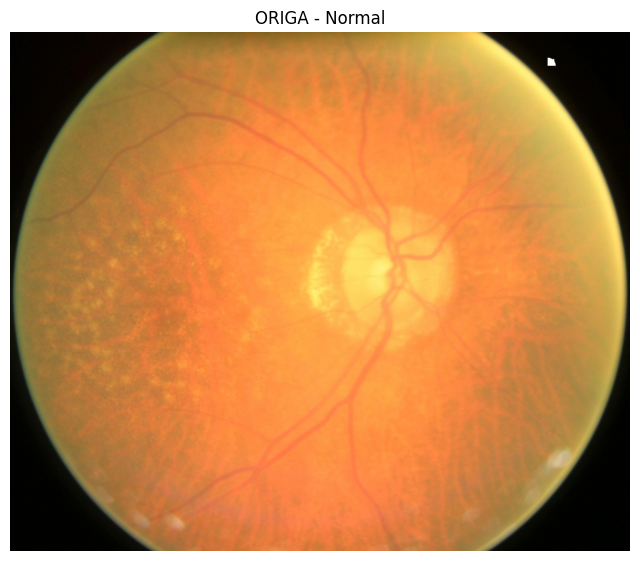

  CDR: 0.5553
  Eye: OD

Image 2 from ORIGA:
  Path: /content/ORIGA/Images/405.jpg
  File ID: 405
  Glaucoma Status: Normal


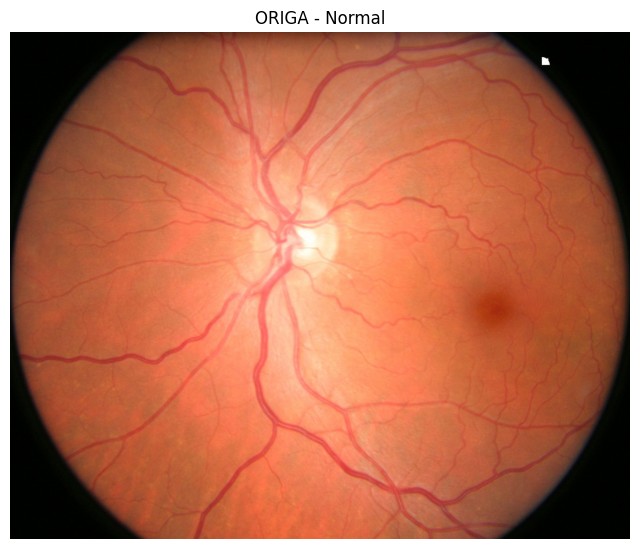

  CDR: 0.4874
  Eye: OS

Attempting to visualize sample images from REFUGE dataset...

Image 1 from REFUGE:
  Path: /content/REFUGE/test/Images/T0379.jpg
  File ID: T0379
  Glaucoma Status: Unknown


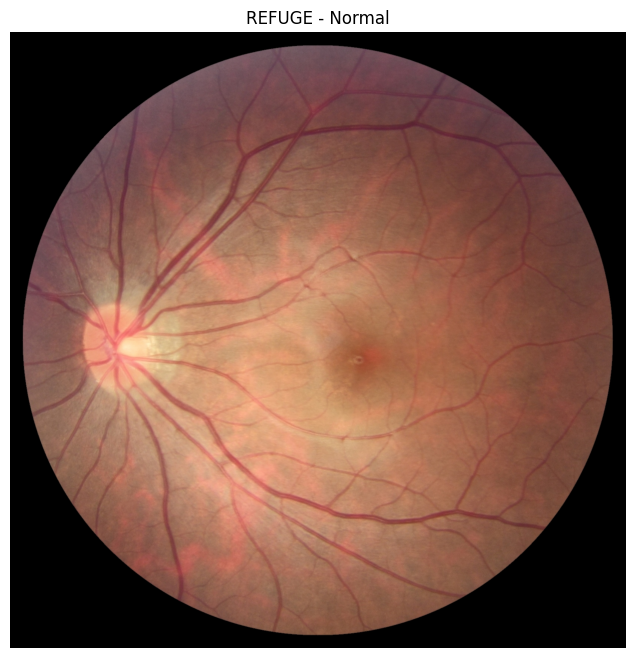


Image 2 from REFUGE:
  Path: /content/REFUGE/test/Images/T0066.jpg
  File ID: T0066
  Glaucoma Status: Unknown


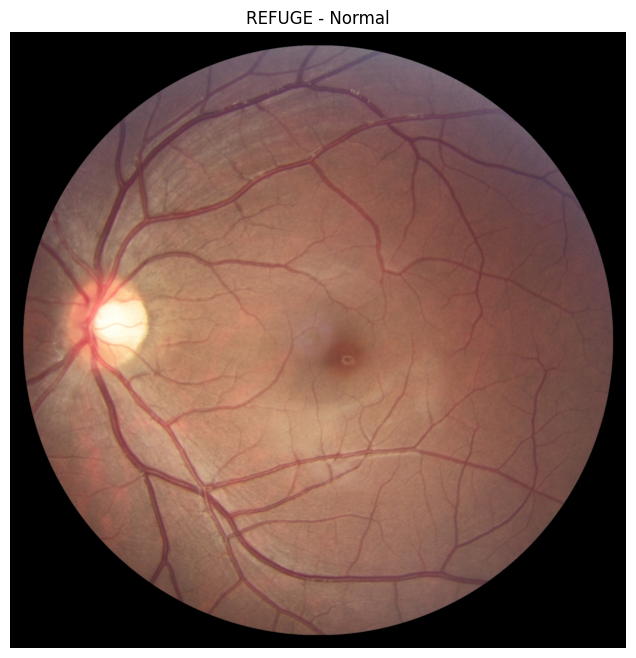


Attempting to visualize sample images from G1020 dataset...

Image 1 from G1020:
  Path: /content/G1020/Images/image_1742.jpg
  File ID: image_1742
  Glaucoma Status: Glaucoma


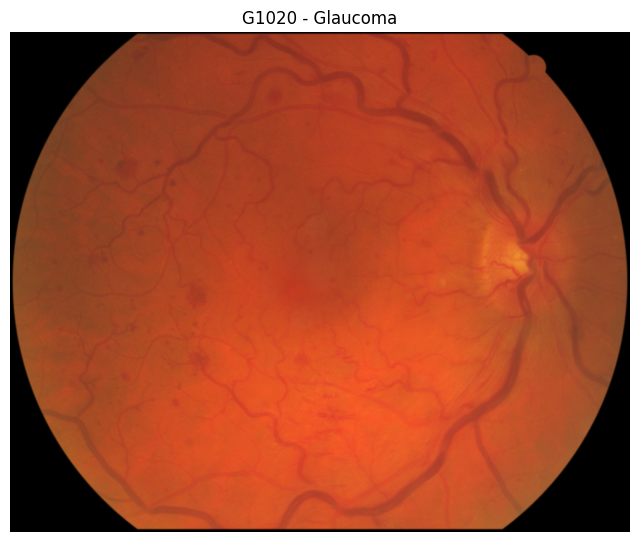


Image 2 from G1020:
  Path: /content/G1020/Images/image_1982.jpg
  File ID: image_1982
  Glaucoma Status: Normal


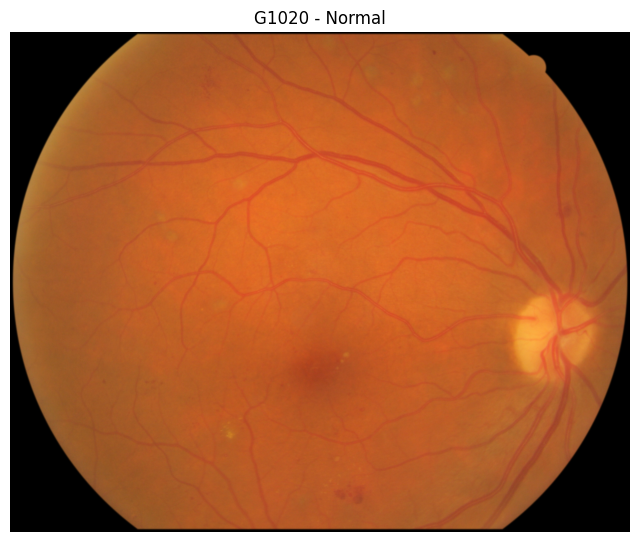


=== EDA COMPLETE ===


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def load_dataset(csv_path):
    """Load the consolidated dataset"""
    print(f"Loading dataset from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples")
    return df

def dataset_overview(df):
    """Provide a general overview of the dataset"""
    print("\n=== DATASET OVERVIEW ===")
    print(f"Total samples: {len(df)}")

    # Dataset distribution
    dataset_counts = df['dataset'].value_counts()
    print("\nSamples per dataset:")
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count} ({count/len(df)*100:.1f}%)")

    # Split distribution
    split_counts = df['split'].value_counts()
    print("\nSamples per split:")
    for split, count in split_counts.items():
        print(f"  {split}: {count} ({count/len(df)*100:.1f}%)")

    # Glaucoma distribution
    glaucoma_counts = df['has_glaucoma'].value_counts()
    print("\nGlaucoma distribution:")
    for label, count in glaucoma_counts.items():
        if label >= 0:  # Skip unknown labels (-1)
            label_text = "Glaucoma" if label == 1 else "Normal"
            print(f"  {label_text}: {count} ({count/len(df[df['has_glaucoma'] >= 0])*100:.1f}%)")

    # Missing values summary
    missing_values = df.isnull().sum()
    print("\nMissing values:")
    for column, count in missing_values.items():
        if count > 0:
            print(f"  {column}: {count} ({count/len(df)*100:.1f}%)")

def plot_dataset_distribution(df):
    """Plot simple bar charts showing dataset distribution"""
    try:
        # Dataset counts
        plt.figure(figsize=(10, 6))
        dataset_counts = df['dataset'].value_counts()
        plt.bar(dataset_counts.index, dataset_counts.values, color=['blue', 'red', 'green'])
        plt.title('Number of Samples by Dataset')
        plt.ylabel('Number of Samples')
        plt.grid(axis='y', alpha=0.3)

        # Add count labels
        for i, count in enumerate(dataset_counts.values):
            plt.text(i, count + 10, str(count), ha='center')

        plt.tight_layout()
        plt.show()

        # Glaucoma distribution
        plt.figure(figsize=(12, 6))

        # Convert to counts
        glaucoma_by_dataset = pd.crosstab(df['dataset'], df['has_glaucoma'])
        if -1 in glaucoma_by_dataset.columns:  # Remove unknown labels
            glaucoma_by_dataset = glaucoma_by_dataset.drop(columns=[-1])

        # Rename columns for clarity
        glaucoma_by_dataset.columns = ['Normal', 'Glaucoma']

        # Plot
        ax = glaucoma_by_dataset.plot(kind='bar', figsize=(10, 6))
        plt.title('Glaucoma vs Normal by Dataset')
        plt.ylabel('Number of Samples')
        plt.grid(axis='y', alpha=0.3)
        plt.legend(title='Class')

        # Add count labels
        for container in ax.containers:
            ax.bar_label(container)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plotting dataset distribution: {e}")
        print("Continuing with text-based analysis...")

def analyze_metadata_availability(df):
    """Analyze the availability of different types of metadata across datasets"""
    print("\n=== METADATA AVAILABILITY ===")

    metadata_cols = ['cdr', 'ecc_cup', 'ecc_disc', 'fovea_x', 'fovea_y', 'eye_laterality']

    # Create a table of metadata availability
    print("\nMetadata Availability by Dataset (%):")

    availability_table = []
    for dataset in df['dataset'].unique():
        row_data = {'Dataset': dataset}
        dataset_df = df[df['dataset'] == dataset]
        for col in metadata_cols:
            non_null_count = dataset_df[col].notna().sum()
            availability_pct = (non_null_count / len(dataset_df)) * 100
            row_data[col] = f"{availability_pct:.1f}%"
        availability_table.append(row_data)

    availability_df = pd.DataFrame(availability_table)
    print(availability_df.to_string(index=False))

    # Print detailed information
    print("\nDetailed metadata availability:")
    for dataset in df['dataset'].unique():
        print(f"\n{dataset} Dataset:")
        dataset_df = df[df['dataset'] == dataset]
        for col in metadata_cols:
            non_null_count = dataset_df[col].notna().sum()
            if non_null_count > 0:
                availability_pct = (non_null_count / len(dataset_df)) * 100
                print(f"  {col}: {non_null_count}/{len(dataset_df)} ({availability_pct:.1f}%)")
            else:
                print(f"  {col}: Not available")

def analyze_image_variants(df):
    """Analyze the availability of different image variants across datasets"""
    print("\n=== IMAGE VARIANTS AVAILABILITY ===")

    image_cols = ['image_path', 'image_cropped_path', 'image_square_path',
                 'mask_path', 'mask_cropped_path', 'mask_square_path', 'nerve_removed_path']

    # Create a table of image variant availability
    print("\nImage Variants Availability by Dataset (%):")

    availability_table = []
    for dataset in df['dataset'].unique():
        row_data = {'Dataset': dataset}
        dataset_df = df[df['dataset'] == dataset]
        for col in image_cols:
            non_null_count = dataset_df[col].notna().sum()
            availability_pct = (non_null_count / len(dataset_df)) * 100
            row_data[col] = f"{availability_pct:.1f}%"
        availability_table.append(row_data)

    availability_df = pd.DataFrame(availability_table)
    print(availability_df.to_string(index=False))

    # Print image dimensions information
    print("\nImage dimensions analysis:")
    for dataset in df['dataset'].unique():
        dataset_df = df[df['dataset'] == dataset]
        valid_dims = dataset_df[['image_width', 'image_height']].dropna()

        if len(valid_dims) > 0:
            unique_dims = valid_dims.groupby(['image_width', 'image_height']).size().reset_index(name='count')
            print(f"\n{dataset} Dataset Dimensions:")
            for _, row in unique_dims.iterrows():
                try:
                    width = int(row['image_width'])
                    height = int(row['image_height'])
                    count = row['count']
                    percentage = (count/len(dataset_df))*100
                    print(f"  {width}x{height}: {count} images ({percentage:.1f}%)")
                except:
                    pass
        else:
            print(f"\n{dataset} Dataset: No dimension information available")

def analyze_cdr_distribution(df):
    """Analyze the Cup-to-Disc Ratio distribution (primarily for ORIGA)"""
    print("\n=== CUP-TO-DISC RATIO ANALYSIS ===")

    # Only proceed if CDR data is available
    cdr_data = df[df['cdr'].notna()]

    if len(cdr_data) == 0:
        print("No Cup-to-Disc Ratio data available in the dataset.")
        return

    print(f"CDR available for {len(cdr_data)} samples ({len(cdr_data)/len(df)*100:.1f}% of dataset)")

    # CDR statistics
    cdr_stats = cdr_data['cdr'].describe()
    print("\nCDR Statistics:")
    print(f"  Mean: {cdr_stats['mean']:.4f}")
    print(f"  Std Dev: {cdr_stats['std']:.4f}")
    print(f"  Min: {cdr_stats['min']:.4f}")
    print(f"  25%: {cdr_stats['25%']:.4f}")
    print(f"  Median: {cdr_stats['50%']:.4f}")
    print(f"  75%: {cdr_stats['75%']:.4f}")
    print(f"  Max: {cdr_stats['max']:.4f}")

    try:
        # Create a simple histogram of CDR values
        plt.figure(figsize=(10, 6))
        plt.hist(cdr_data['cdr'], bins=20, alpha=0.7, color='blue')
        plt.title('Cup-to-Disc Ratio Distribution')
        plt.xlabel('Cup-to-Disc Ratio (CDR)')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Box plot of CDR by glaucoma status (if available)
        glaucoma_cdr = cdr_data[cdr_data['has_glaucoma'] == 1]['cdr']
        normal_cdr = cdr_data[cdr_data['has_glaucoma'] == 0]['cdr']

        if len(glaucoma_cdr) > 0 and len(normal_cdr) > 0:
            plt.figure(figsize=(8, 6))
            plt.boxplot([normal_cdr, glaucoma_cdr], labels=['Normal', 'Glaucoma'])
            plt.title('CDR Distribution by Glaucoma Status')
            plt.ylabel('Cup-to-Disc Ratio (CDR)')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting CDR distribution: {e}")

    # Calculate the CDR threshold for classification
    print("\nCDR Threshold Analysis:")
    for threshold in [0.5, 0.6, 0.7, 0.8]:
        prediction = (cdr_data['cdr'] > threshold).astype(int)
        correct = (prediction == cdr_data['has_glaucoma']).sum()
        accuracy = correct / len(cdr_data) * 100
        print(f"  CDR > {threshold} threshold: {accuracy:.1f}% accuracy")

def visualize_sample_images(df, num_samples=2):
    """Visualize a few sample images from each dataset"""
    print("\n=== SAMPLE IMAGES VISUALIZATION ===")

    for dataset in df['dataset'].unique():
        print(f"\nAttempting to visualize sample images from {dataset} dataset...")

        # Get subset of dataset with available image paths
        dataset_df = df[(df['dataset'] == dataset) & (df['image_path'].notna())]

        if len(dataset_df) == 0:
            print(f"No images with valid paths found for {dataset}")
            continue

        # Sample images
        samples = dataset_df.sample(min(num_samples, len(dataset_df)), random_state=42)

        for i, (_, row) in enumerate(samples.iterrows()):
            img_path = row['image_path']

            if pd.isna(img_path) or not os.path.exists(img_path):
                print(f"  Image path does not exist: {img_path}")
                continue

            try:
                # Display image information
                print(f"\nImage {i+1} from {dataset}:")
                print(f"  Path: {img_path}")
                print(f"  File ID: {row['file_id']}")
                print(f"  Glaucoma Status: {'Glaucoma' if row['has_glaucoma'] == 1 else 'Normal' if row['has_glaucoma'] == 0 else 'Unknown'}")

                # Try to load and display image
                try:
                    img = Image.open(img_path)
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img)
                    plt.title(f"{dataset} - {'Glaucoma' if row['has_glaucoma'] == 1 else 'Normal'}")
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"  Error displaying image: {e}")

                # Print additional metadata if available
                if pd.notna(row['cdr']):
                    print(f"  CDR: {row['cdr']:.4f}")
                if pd.notna(row['fovea_x']) and pd.notna(row['fovea_y']):
                    print(f"  Fovea Location: ({row['fovea_x']:.1f}, {row['fovea_y']:.1f})")
                if pd.notna(row['eye_laterality']):
                    print(f"  Eye: {row['eye_laterality']}")

            except Exception as e:
                print(f"  Error processing image {img_path}: {e}")

def summarize_dataset_characteristics(df):
    """Create a summary of unique characteristics for each dataset"""
    print("\n=== DATASET CHARACTERISTICS SUMMARY ===")

    for dataset in df['dataset'].unique():
        dataset_df = df[df['dataset'] == dataset]

        print(f"\n{dataset} Dataset:")
        print(f"  Total samples: {len(dataset_df)}")

        # Class distribution
        try:
            glaucoma_count = dataset_df[dataset_df['has_glaucoma'] == 1].shape[0]
            normal_count = dataset_df[dataset_df['has_glaucoma'] == 0].shape[0]
            glaucoma_pct = glaucoma_count / (glaucoma_count + normal_count) * 100
            print(f"  Class Distribution: {glaucoma_count} Glaucoma ({glaucoma_pct:.1f}%), {normal_count} Normal ({100-glaucoma_pct:.1f}%)")
        except:
            print("  Class Distribution: Not available")

        # Splits
        splits = dataset_df['split'].unique()
        print(f"  Dataset Splits: {', '.join(splits)}")

        # Available image variants
        variants = []
        if dataset_df['image_path'].notna().any():
            variants.append("Original Images")
        if dataset_df['image_cropped_path'].notna().any():
            variants.append("Cropped Images")
        if dataset_df['image_square_path'].notna().any():
            variants.append("Square Images")
        if dataset_df['mask_path'].notna().any():
            variants.append("Segmentation Masks")
        if dataset_df['nerve_removed_path'].notna().any():
            variants.append("Nerve-Removed Images")
        print(f"  Available Variants: {', '.join(variants)}")

        # Unique metadata
        metadata = []
        if dataset_df['cdr'].notna().any():
            metadata.append("Cup-to-Disc Ratio (CDR)")
        if dataset_df['ecc_cup'].notna().any():
            metadata.append("Cup Eccentricity")
        if dataset_df['ecc_disc'].notna().any():
            metadata.append("Disc Eccentricity")
        if dataset_df['fovea_x'].notna().any():
            metadata.append("Fovea Coordinates")
        if dataset_df['eye_laterality'].notna().any():
            metadata.append("Eye Laterality (OD/OS)")
        print(f"  Available Metadata: {', '.join(metadata) if metadata else 'None'}")

        # Image dimensions if available
        valid_dims = dataset_df[['image_width', 'image_height']].dropna()
        if len(valid_dims) > 0:
            dims = valid_dims.groupby(['image_width', 'image_height']).size().reset_index()
            dim_strs = []
            for _, row in dims.iterrows():
                try:
                    dim_strs.append(f"{int(row['image_width'])}x{int(row['image_height'])}")
                except:
                    pass
            print(f"  Image Dimensions: {', '.join(dim_strs)}")
        else:
            print("  Image Dimensions: Not available")

def main():
    # Load the consolidated dataset
    csv_path = '/content/consolidated_glaucoma_dataset.csv'
    df = load_dataset(csv_path)

    # General dataset overview
    dataset_overview(df)

    # Create a summary of dataset characteristics
    summarize_dataset_characteristics(df)

    # Plot dataset distributions
    plot_dataset_distribution(df)

    # Analyze availability of metadata
    analyze_metadata_availability(df)

    # Analyze image variants
    analyze_image_variants(df)

    # Analyze CDR distribution (if available)
    analyze_cdr_distribution(df)

    # Visualize sample images from each dataset
    visualize_sample_images(df, num_samples=2)

    print("\n=== EDA COMPLETE ===")

if __name__ == "__main__":
    main()

---

# 2. Things I need to for code:

1. clean the train/test/val column
2. remove the metadeta columns
3. Convert the csv file into pytorch dataset
4. Make the pipeline for the evaluation metrics and model training framework for everyone.
5. Try different models until you are tired.
6. Make a novel architecture that I am thinking of.